In [1]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from torch.utils.data import TensorDataset, DataLoader
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

<font size="6">**Homework #3: Neural Networks**</font>  
  
### **Part 1: PyTorch Implementation with MCE**

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)


#### Construct Net3 with a single hidden layer
##### We used tanh as our activation function. To add a bias term, we set bias=True in the nn.Linear module.

In [3]:
class net3(nn.Module):
    def __init__(self,input_size,nodes,output_size):
        super(net3,self).__init__()
        #we use linear calculation from input to hidden layer, with bias
        self.l1 = nn.Linear(input_size,nodes,bias=True)
        #we use tanh function as our activation function
        self.activation = nn.Tanh()
        #we use linear calculation from hidden layer to output layer, with bias
        self.output_layer = nn.Linear(nodes, output_size, bias=True)

    def forward(self,x):
        #Hidden Layer with k nodes
        x = self.l1(x)
        #Activation Function
        x = self.activation(x)
        #Output Layer
        x = self.output_layer(x)
        return x


##### To train our model, we defined our loss function as multi-class cross entropy, and adopted gradient descent as our training approach. We keep track of training loss and validation loss for every epoch for visualization.

In [4]:
def train_model(name, model, learning_rate=0.01, epochs=100):
    # Read training data
    x_train, y_train, _ = read_data(name, 'train')
    x_val, y_val, _ = read_data(name, 'valid')

    # Convert to PyTorch tensors
    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_val = torch.tensor(x_val, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long).squeeze()
    y_val = torch.tensor(y_val, dtype=torch.long).squeeze() 

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_dataset = TensorDataset(x_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # Initialize lists to store loss history
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            predictions = model(x)
            loss = criterion(predictions, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation loop
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                output = model(x)
                val_loss = criterion(output, y)
                epoch_val_loss += val_loss.item()

        # Calculate average losses
        avg_train_loss = epoch_loss / len(train_loader.dataset)
        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        # Store the losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print training progress
        # if (epoch + 1) % 50 == 0:
        #     print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return model, train_losses, val_losses

##### To evaluate our model, we calculate and print the accuracy on test dataset

In [5]:
def evaluate_model(name, model):
    x_test, y_test, _ = read_data(name, 'test')

    # Convert to PyTorch tensors
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long).squeeze()
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    # Initialize counters
    correct = 0
    total = 0

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for x,y in test_loader:
            predictions = model(x)
            predicted_classes = predictions.argmax(dim=1)  # Get the predicted class indices
            correct += (predicted_classes == y).sum().item()
            total += y.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

##### Here is the drawing function for result visualization using the test data

In [6]:
def draw_example(nodes, name, model):
    x_train, y_train, label_train = read_data(name, 'train')
    x_test, y_test, label_test = read_data(name, 'test')

    fig, ax = plt.subplots(figsize=(6, 6))

    h = 0.05  # step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    # Define grid range
    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Prepare grid data for predictions
    grid_data = np.c_[xx.ravel(), yy.ravel()]
    grid_data = np.hstack((np.ones((grid_data.shape[0], 1)), grid_data))  # Add bias term
    grid_tensor = torch.tensor(grid_data, dtype=torch.float32)

    # Get predictions for the entire grid
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)  # Shape: (num_points, num_classes)
        Z = preds.argmax(dim=1).numpy()  # Get class predictions

    # Reshape predictions to match the grid
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and test data
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:, 0], cmap=cmap_bold, edgecolor='k', s=20)
    plt.show()

##### Here is the drawing function to plot the learning curves for training and validation loss as a function of training epochs

In [7]:
def plot_learning_curves(train_losses,val_losses,epochs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

### **Dataset 1: xor**

In [8]:
name = 'xor'
learning_rate = 0.01
epochs =1000

##### Hidden layer with k=3 nodes, learning rate=0.01, epochs=1000


Training with k=2
Test Accuracy: 0.6900


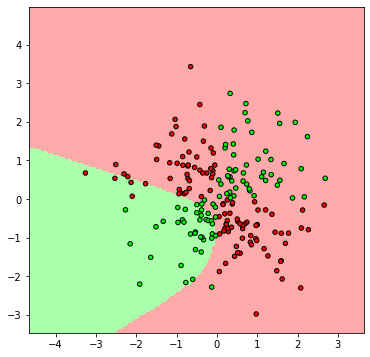

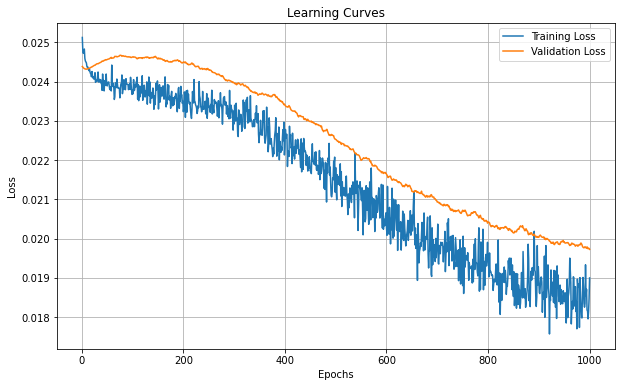


Training with k=3
Test Accuracy: 0.8400


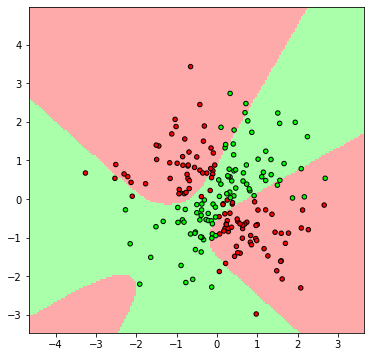

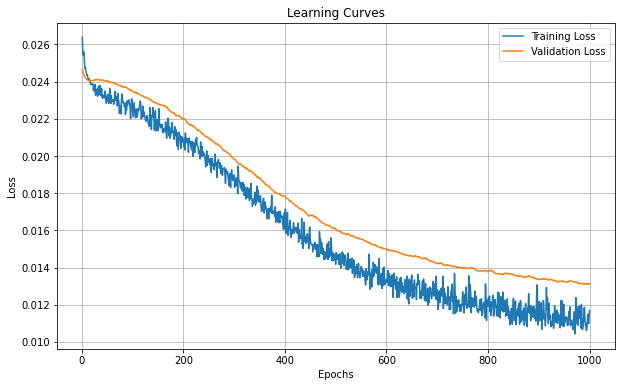


Training with k=5
Test Accuracy: 0.9050


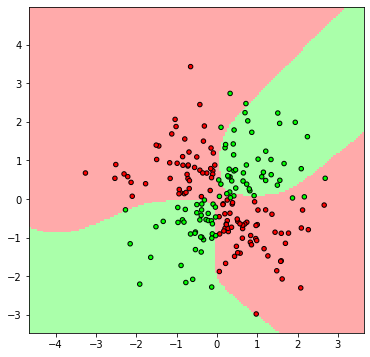

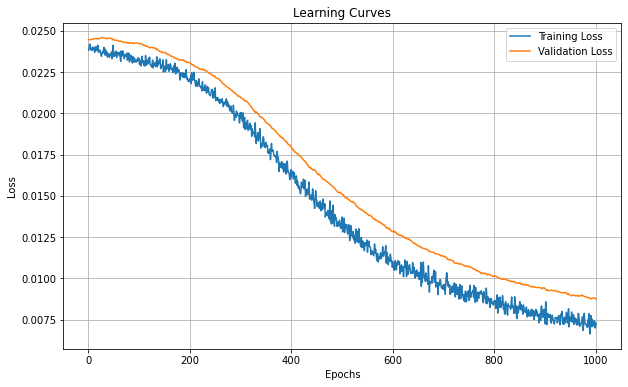


Training with k=7
Test Accuracy: 0.9050


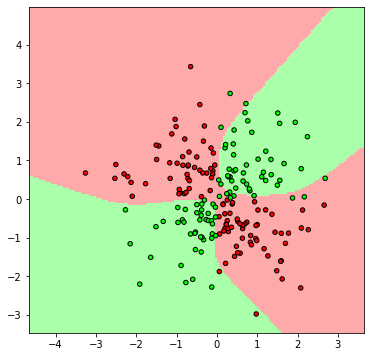

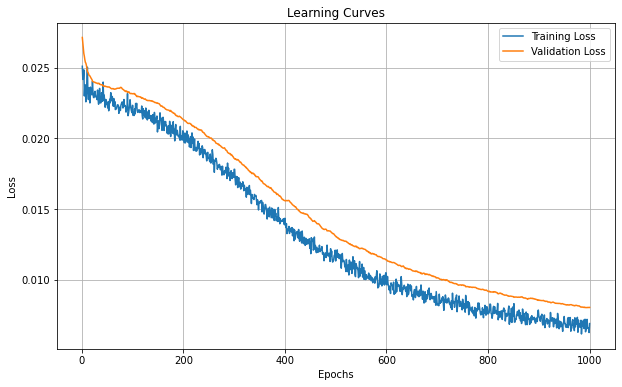


Training with k=9
Test Accuracy: 0.9250


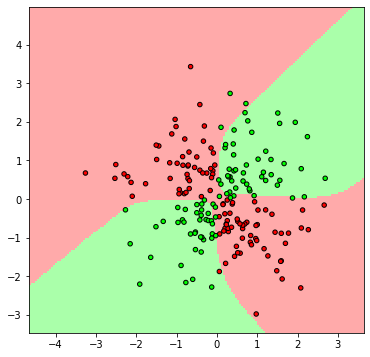

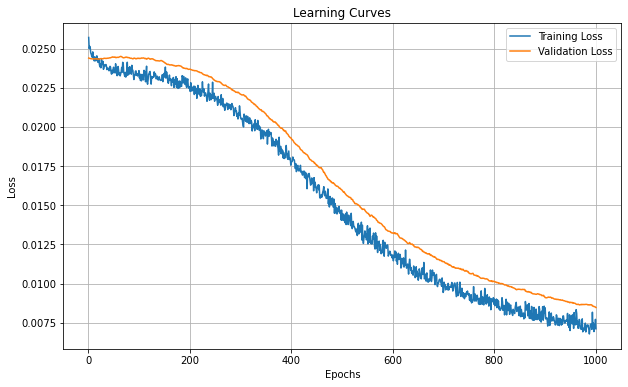

In [9]:
for k in [2,3,5,7,9]:
    print(f"\nTraining with k={k}")
    model = net3(input_size=3,nodes=k,output_size=2)
    trained_model, train_losses, val_losses = train_model(name=name, model=model, learning_rate=learning_rate, epochs=epochs)
    test_acc = evaluate_model(name,trained_model)
    draw_example(k,name,model=trained_model)
    plot_learning_curves(train_losses,val_losses,epochs)

### Thoughts on the choice of optimal k number
#####   For xor dataset, k=7/k=9 return a same final test accuracy which is much higher when k=2/3/5. For small k, the hidden layer might not have sufficient neurons to fully model the XOR function’s decision boundaries. This could lead to underfitting, where the network lacks the representational power to perfectly separate the classes.
##### For k=7 or k=9, the hidden layer likely has enough neurons to fully capture the XOR function’s complexity. Once the network reaches this sufficient capacity, increasing the number of neurons further (from 7 to 9) may not provide additional accuracy gains because the problem doesn’t require more capacity than that to achieve the highest accuracy.

### **Dataset 2: center_surround**

In [10]:
name = 'center_surround'
learning_rate = 0.01
epochs =1000


Training with k=2
Test Accuracy: 0.7000


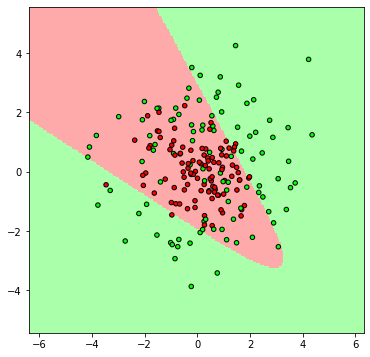

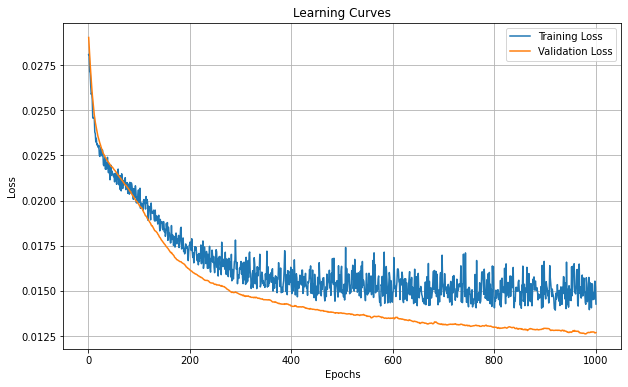


Training with k=3
Test Accuracy: 0.7550


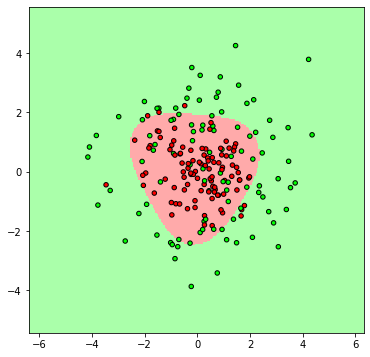

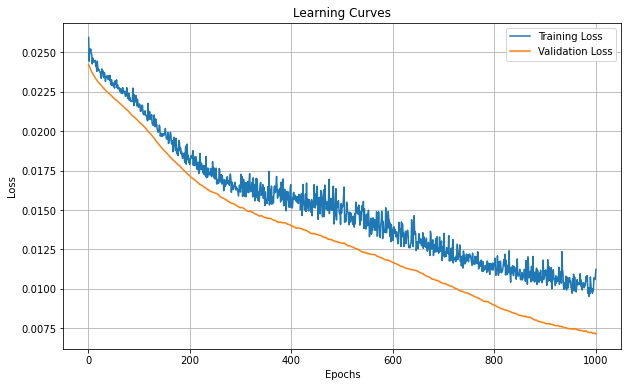


Training with k=5
Test Accuracy: 0.7750


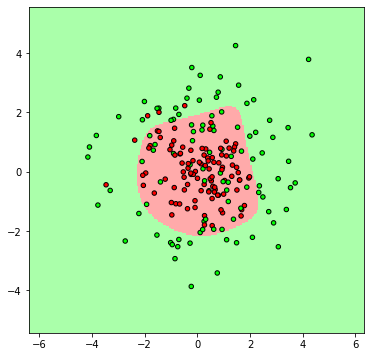

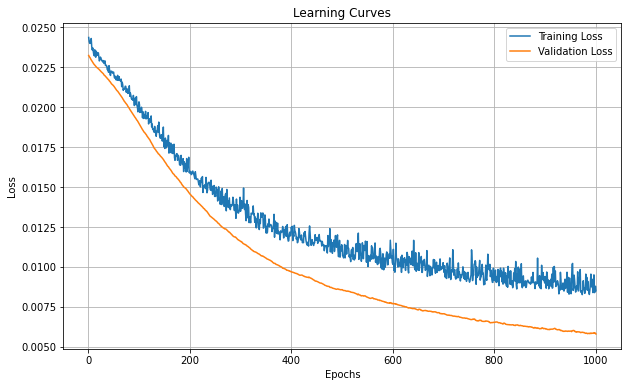


Training with k=7
Test Accuracy: 0.7650


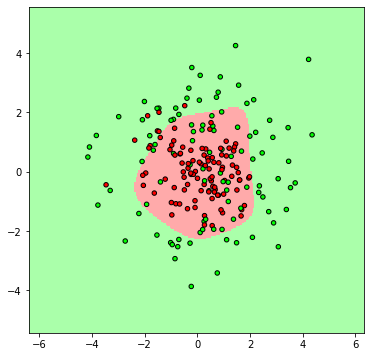

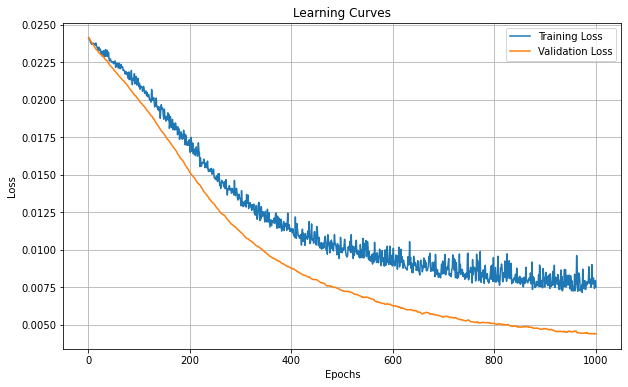


Training with k=9
Test Accuracy: 0.7650


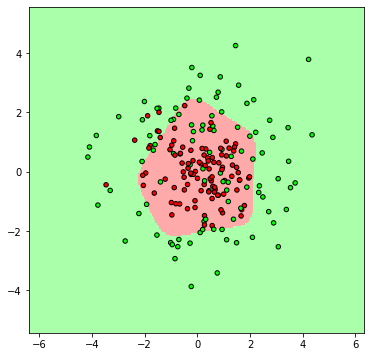

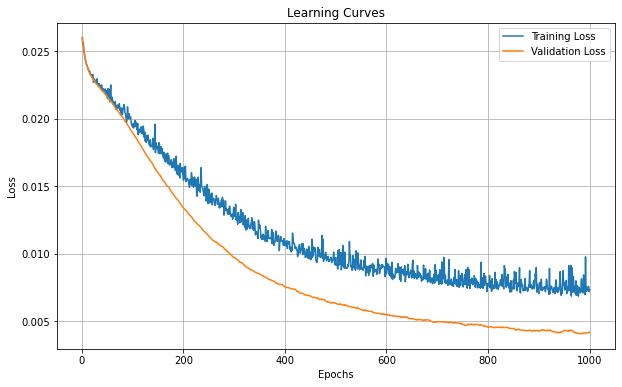

In [11]:
for k in [2,3,5,7,9]:
    print(f"\nTraining with k={k}")
    model = net3(input_size=3,nodes=k,output_size=2)
    trained_model, train_losses, val_losses = train_model(name=name, model=model, learning_rate=learning_rate, epochs=epochs)
    test_acc = evaluate_model(name,trained_model)
    draw_example(k,name,model=trained_model)
    plot_learning_curves(train_losses,val_losses,epochs)

### Thoughts on the choice of optimal k number
##### The center surround dataset seems to have a more complex, non-linear decision boundary. In this case, increasing the number of hidden layer nodes (k) improves the performance, and the number of 9 nodes provide the best performance.
##### When k is small (e.g.k=2, k=3 or k=5), the network doesn’t have enough neurons to capture the intricate non-linear boundaries. The decision regions will be simpler, leading to misclassifications.

### **Dataset 3: two_gaussians**

In [12]:
name = 'two_gaussians'
learning_rate = 0.01
epochs =100


Training with k=2
Test Accuracy: 0.9200


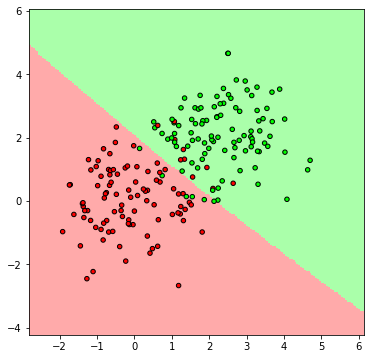

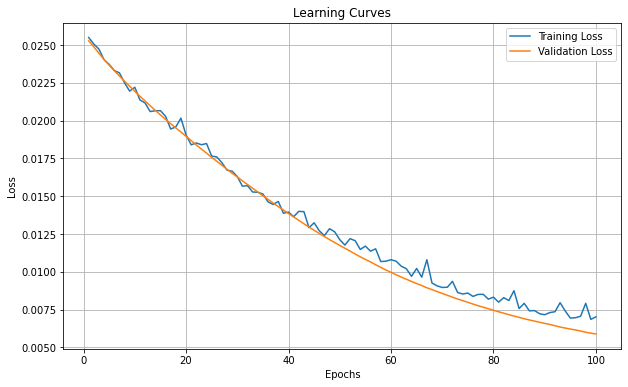


Training with k=3
Test Accuracy: 0.9050


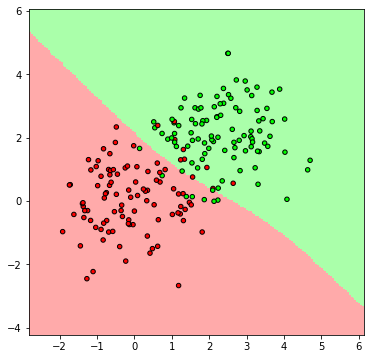

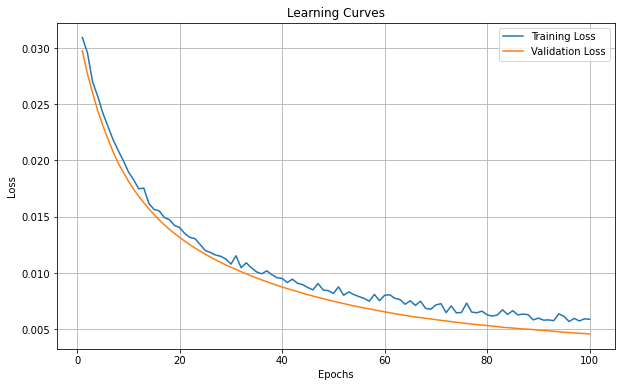


Training with k=5
Test Accuracy: 0.9250


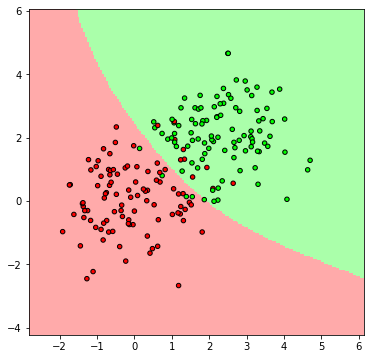

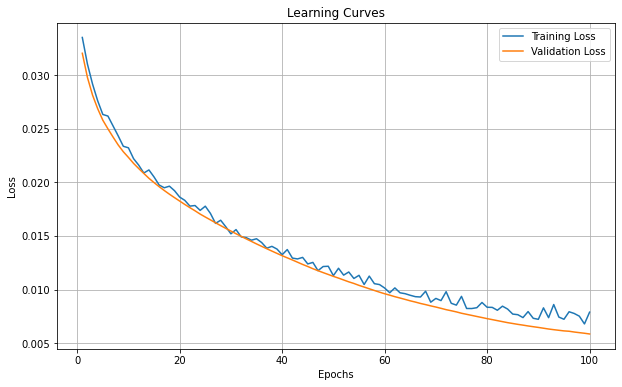


Training with k=7
Test Accuracy: 0.9200


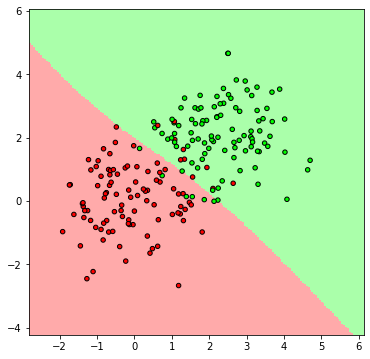

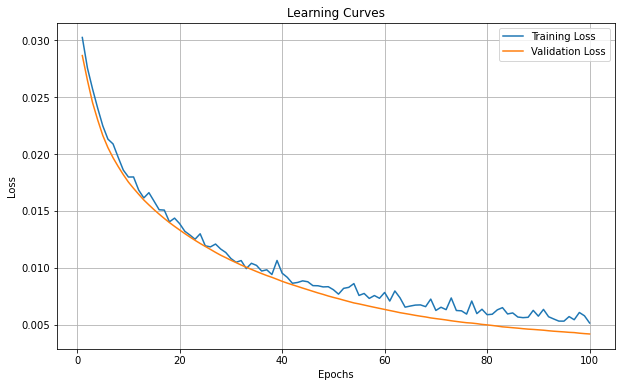


Training with k=9
Test Accuracy: 0.9050


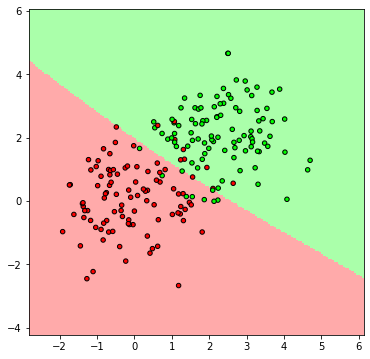

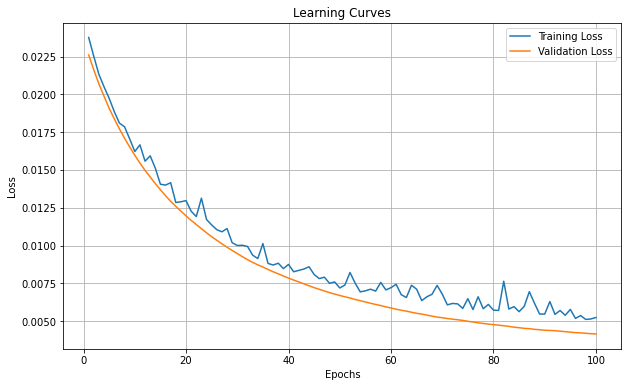

In [13]:
for k in [2,3,5,7,9]:
    print(f"\nTraining with k={k}")
    model = net3(input_size=3,nodes=k,output_size=2)
    trained_model, train_losses, val_losses = train_model(name=name, model=model, learning_rate=learning_rate, epochs=epochs)
    test_acc = evaluate_model(name,trained_model)
    draw_example(k,name,model=trained_model)
    plot_learning_curves(train_losses,val_losses,epochs)

### Thoughts on the choice of optimal k number
##### The number of 3 nodes appears to be optimal. The two gaussian dataset appears to have a linear or near-linear decision boundary separating the two classes. The data distribution suggests that a linear decision boundary is sufficient to separate the two classes effectively. When the hidden layer has fewer nodes (e.g.k=3), the model’s capacity is limited, encouraging it to find simpler, more generalizable patterns, which aligns well with this dataset’s linear structure.
##### For this dataset, a complex boundary with more hidden nodes is unnecessary and might cause the model to overfit noise in the data, leading to worse generalization on the test set.

### **Dataset 4: spiral**

In [14]:
name = 'spiral'
learning_rate = 0.01
epochs =1000


Training with k=2
Test Accuracy: 0.7200


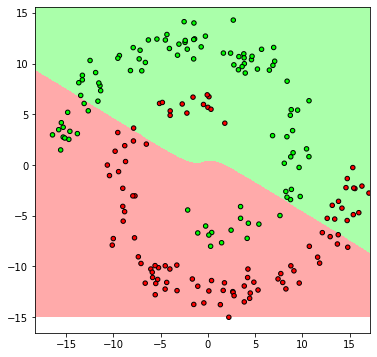

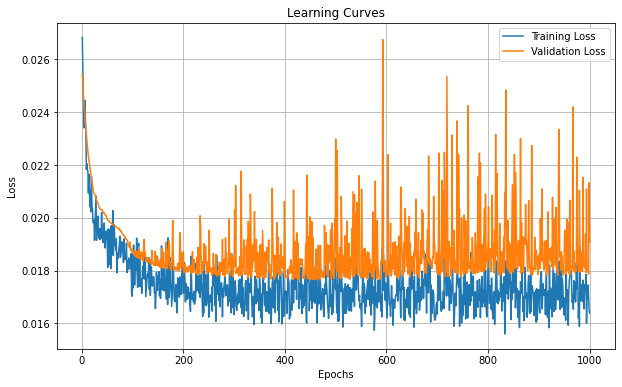


Training with k=3
Test Accuracy: 0.8050


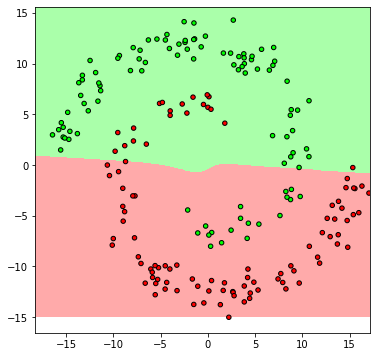

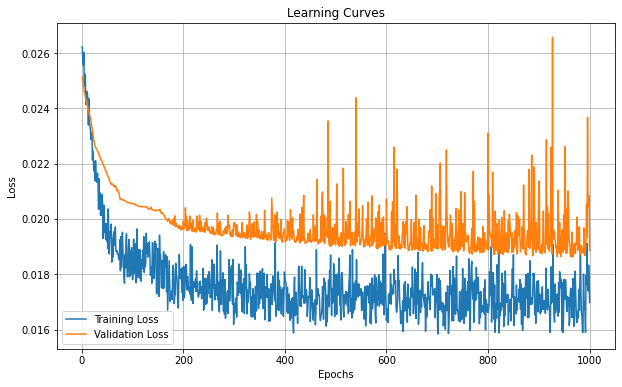


Training with k=5
Test Accuracy: 0.9450


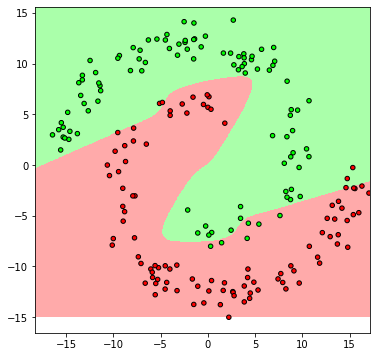

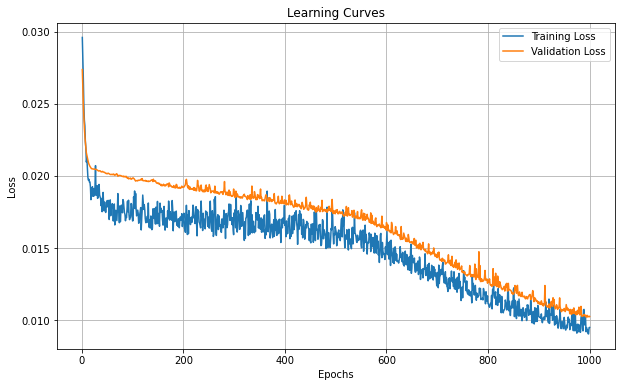


Training with k=7
Test Accuracy: 0.9650


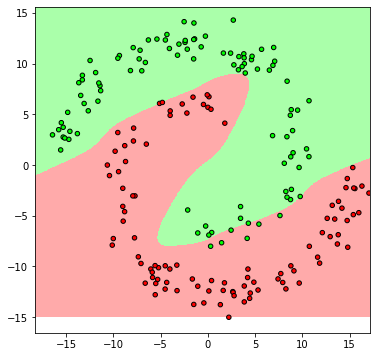

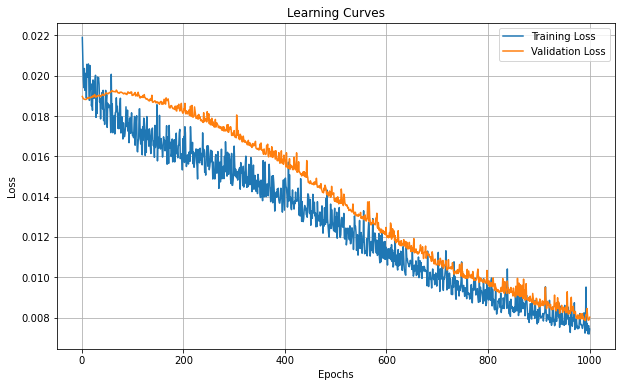


Training with k=9
Test Accuracy: 0.9550


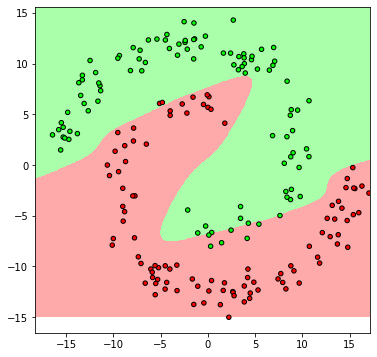

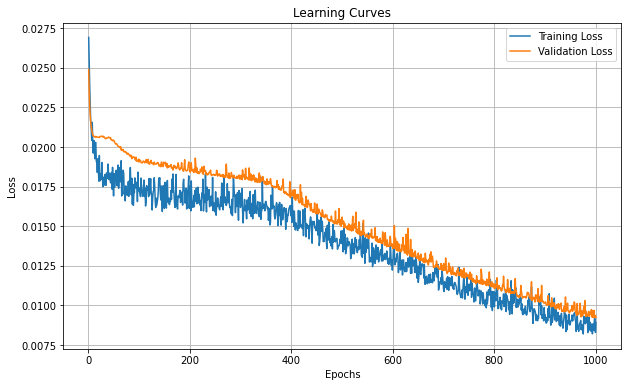

In [15]:
for k in [2,3,5,7,9]:
    print(f"\nTraining with k={k}")
    model = net3(input_size=3,nodes=k,output_size=2)
    trained_model, train_losses, val_losses = train_model(name=name, model=model, learning_rate=learning_rate, epochs=epochs)
    test_acc = evaluate_model(name,trained_model)
    draw_example(k,name,model=trained_model)
    plot_learning_curves(train_losses,val_losses,epochs)

### Thoughts on the choice of optimal k number
##### Number of 9 is the optimal. The sqiral dataset exhibits a highly non-linear and complex decision boundary. With a larger k, the neural network has more nodes in the hidden layer, which increases its capacity to represent complex, non-linear boundaries. This allows the model to better approximate the true decision boundary.
##### With small k (e.g.3 or 5), the model lacks the representational power to capture the twists and turns of the decision boundary. It may approximate it as a simpler, smoother shape, which leads to underfitting and misclassification.

### **Part 2: PyTorch Implementation with MSE**
##### Add a sigmoid function as the output layer

In [16]:
class net3(nn.Module):
    def __init__(self,input_size,nodes,output_size):
        super(net3,self).__init__()
        #we use linear calculation from input to hidden layer, with bias
        self.l1 = nn.Linear(input_size,nodes,bias=True)
        #we use tanh function as our activation function
        self.activation = nn.ReLU()
        #we use linear calculation from hidden layer to output layer, with bias
        self.output_layer = nn.Linear(nodes, output_size, bias=True)

    def forward(self,x):
        #Hidden Layer with k nodes
        x = self.l1(x)
        #Activation Function
        x = self.activation(x)
        #Output Layer
        x = self.output_layer(x)
        # Apply Sigmoid to scale output to [0, 1]
        x = torch.sigmoid(x) 
        return x

In [17]:
def train_model(name, model, learning_rate=0.01, epochs=100):
    # Read training data
    x_train, y_train, _ = read_data(name, 'train')
    x_val, y_val, _ = read_data(name, 'valid')

    # Convert to PyTorch tensors
    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_val = torch.tensor(x_val, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_dataset = TensorDataset(x_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # Initialize lists to store loss history
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            predictions = model(x)
            loss = criterion(predictions, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation loop
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                output = model(x)
                val_loss = criterion(output, y)
                epoch_val_loss += val_loss.item()

        # Calculate average losses
        avg_train_loss = epoch_loss / len(train_loader.dataset)
        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        # Store the losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print training progress
        # if (epoch + 1) % 50 == 0:
        #     print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return model, train_losses, val_losses

In [18]:
def evaluate_model(name, model):
    x_test, y_test, _ = read_data(name, 'test')

    # Convert to PyTorch tensors
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    # Initialize counters
    correct = 0
    total = 0

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for x,y in test_loader:
            # Get raw logits from the model
            output = model(x)
            
            # Apply threshold=0.5 to assign binary labels
            predicted_classes = (output >= 0.5).float()

            # Calculate accuracy
            correct += (predicted_classes == y).sum().item()
            total += y.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

In [19]:
def draw_example(nodes, name, model):
    x_train, y_train, label_train = read_data(name, 'train')
    x_test, y_test, label_test = read_data(name, 'test')

    fig, ax = plt.subplots(figsize=(6, 6))

    h = 0.05  # step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    # Define grid range
    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Prepare grid data for predictions
    grid_data = np.c_[xx.ravel(), yy.ravel()]
    grid_data = np.hstack((np.ones((grid_data.shape[0], 1)), grid_data))  # Add bias term
    grid_tensor = torch.tensor(grid_data, dtype=torch.float32)

    # Get predictions for the entire grid
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)  # Shape: (num_points, 1)
        Z = (preds >= 0.5).float()  # Threshold at 0.5 to classify as 0 or 1

    # Reshape predictions to match the grid
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and test data
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:, 0], cmap=cmap_bold, edgecolor='k', s=20)
    plt.show()

In [20]:
def plot_learning_curves(train_losses,val_losses,epochs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

### **Dataset 1: xor**

In [21]:
name = 'xor'
learning_rate = 0.01
epochs =1000


Training with k=2
Test Accuracy: 0.6650


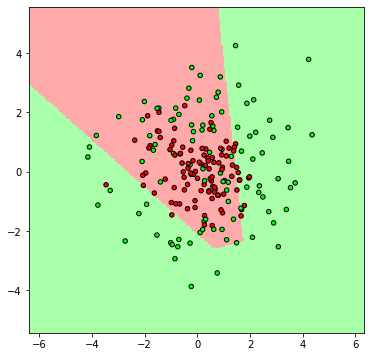

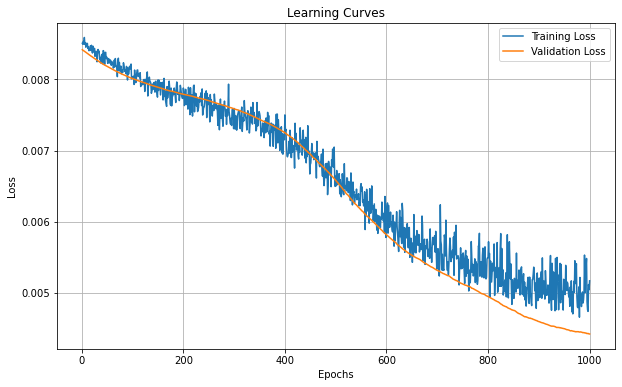


Training with k=3
Test Accuracy: 0.6450


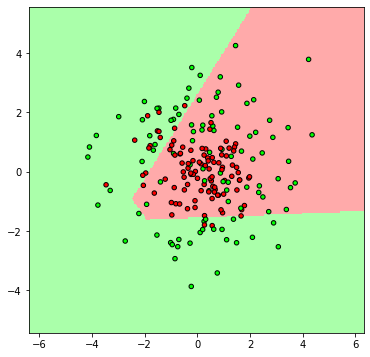

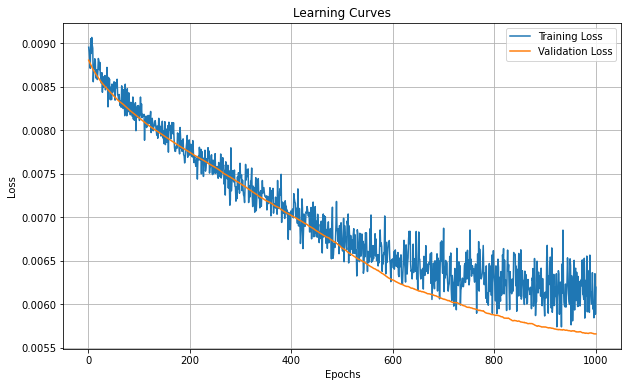


Training with k=5
Test Accuracy: 0.7750


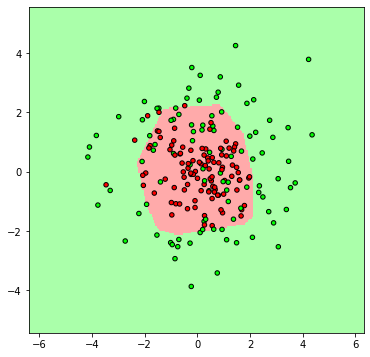

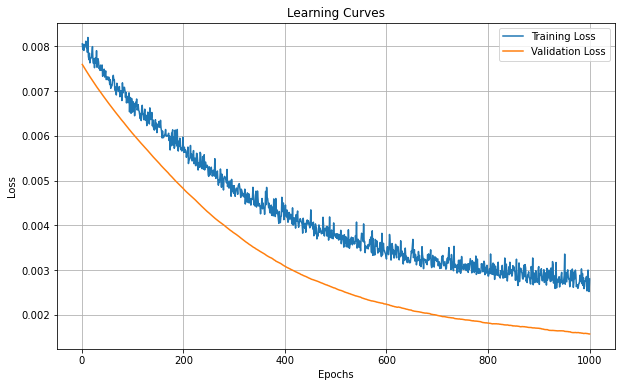


Training with k=7
Test Accuracy: 0.7500


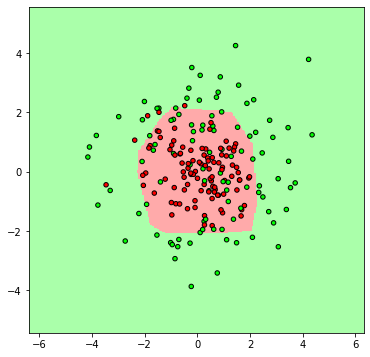

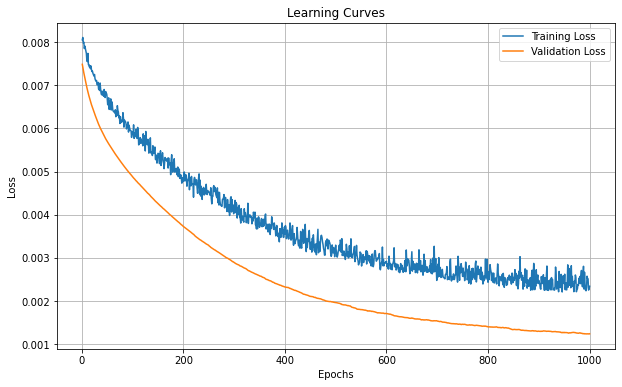


Training with k=9
Test Accuracy: 0.7550


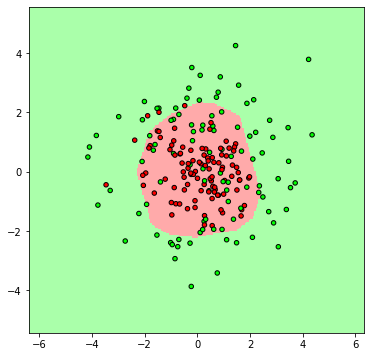

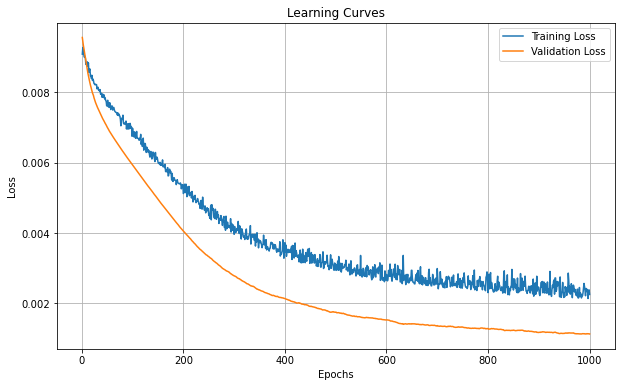

In [26]:
for k in [2,3,5,7,9]:
    print(f"\nTraining with k={k}")
    model = net3(3,k,1)
    trained_model, train_losses, val_losses = train_model(name, model, learning_rate=learning_rate, epochs=epochs)
    test_acc = evaluate_model(name,trained_model)
    draw_example(k,name,model=trained_model)
    plot_learning_curves(train_losses,val_losses,epochs)

### **Dataset 2: center_surround**

In [23]:
name = 'center_surround'
learning_rate = 0.01
epochs =1000


Training with k=2
Test Accuracy: 0.5800


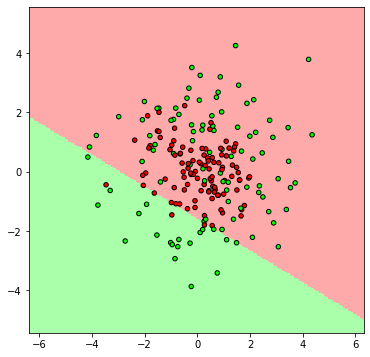

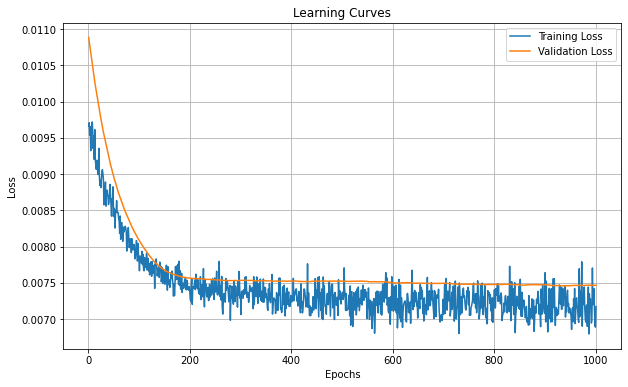


Training with k=3
Test Accuracy: 0.6900


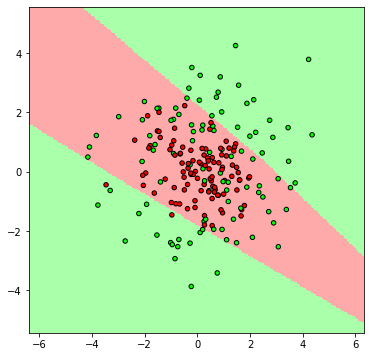

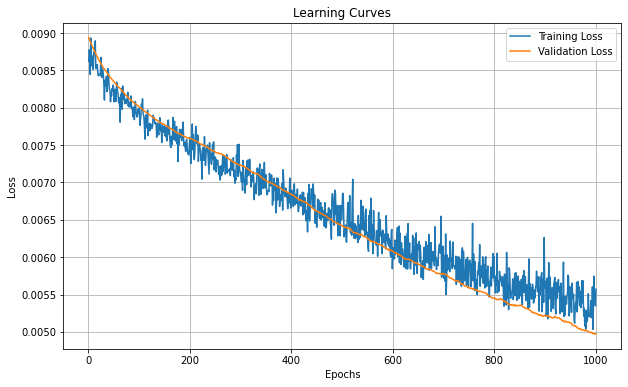


Training with k=5
Test Accuracy: 0.7700


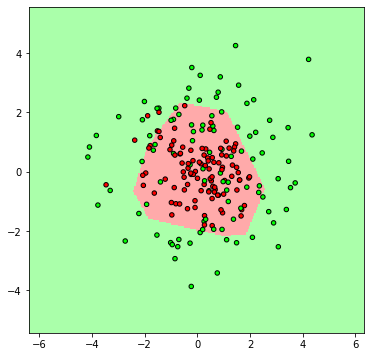

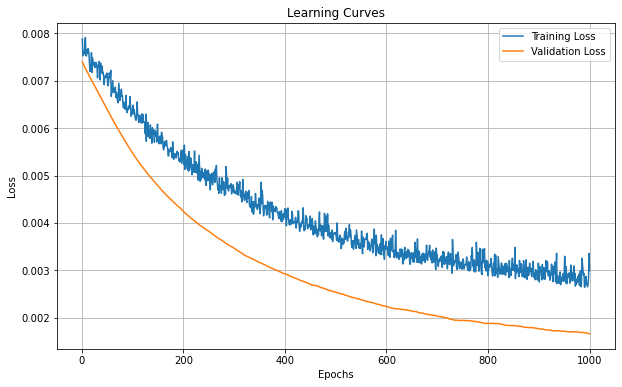


Training with k=7
Test Accuracy: 0.7650


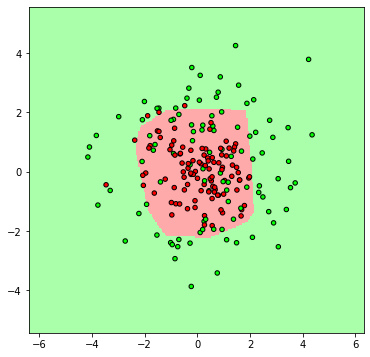

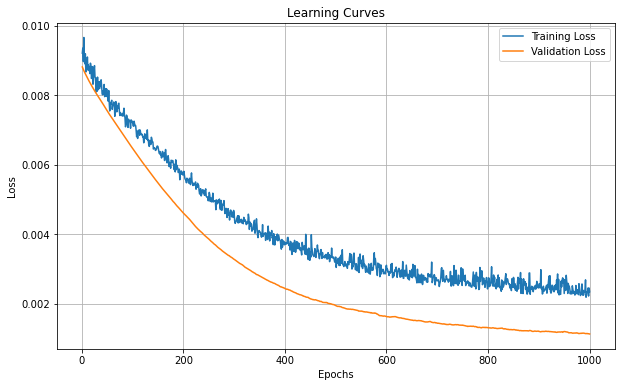


Training with k=9
Test Accuracy: 0.7650


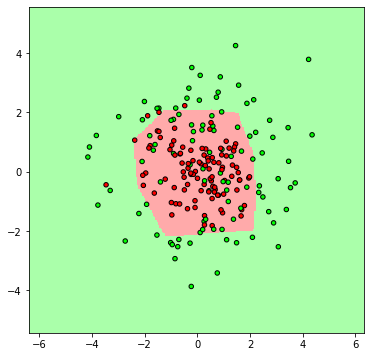

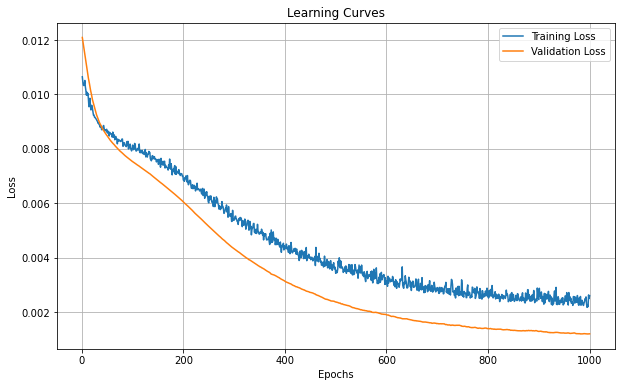

In [24]:
for k in [2,3,5,7,9]:
    print(f"\nTraining with k={k}")
    model = net3(3,k,1)
    trained_model, train_losses, val_losses = train_model(name, model, learning_rate=learning_rate, epochs=epochs)
    test_acc = evaluate_model(name,trained_model)
    draw_example(k,name,model=trained_model)
    plot_learning_curves(train_losses,val_losses,epochs)